In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
import pickle
from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow as tf

#Tensorflow Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import pydot
import pydotplus
import graphviz
 

#Tensorflow Functional
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,concatenate
from tensorflow.keras.utils import plot_model

#Image Processor
import os
import cv2
import glob
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import ( RandomFlip, RandomRotation, RandomContrast, RandomZoom)
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption



# For ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train=pd.read_csv("Composed Worm AI.v1i.tensorflow/train/_annotations.csv")
data_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,37-11-May-2024_png.rf.5993e06cbbcb385d8e2fe8a7...,640,640,spinach,150,35,365,181
1,37-11-May-2024_png.rf.5993e06cbbcb385d8e2fe8a7...,640,640,spinach,49,175,283,347
2,37-11-May-2024_png.rf.5993e06cbbcb385d8e2fe8a7...,640,640,cardboard,188,209,288,269
3,37-11-May-2024_png.rf.5993e06cbbcb385d8e2fe8a7...,640,640,cardboard,23,236,75,274
4,37-11-May-2024_png.rf.5993e06cbbcb385d8e2fe8a7...,640,640,cardboard,70,25,208,131
...,...,...,...,...,...,...,...,...
192,28-28-Apr-2024_png.rf.d46bfdf5291fef975c9ceb4a...,640,640,cardboard,112,40,175,97
193,28-28-Apr-2024_png.rf.d46bfdf5291fef975c9ceb4a...,640,640,cardboard,72,49,140,147
194,28-28-Apr-2024_png.rf.d46bfdf5291fef975c9ceb4a...,640,640,cardboard,0,371,78,479
195,28-28-Apr-2024_png.rf.d46bfdf5291fef975c9ceb4a...,640,640,cardboard,0,16,27,92


In [3]:
data_train['class'].value_counts()

class
cardboard    132
leaves        59
spinach        6
Name: count, dtype: int64

In [18]:
def custom_draw_caption(image, box, caption, color=(0, 255, 0)):
    """ Draws a caption above the box in the image. """
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def show_image_objects(image_row, images_dir):
    img_path = os.path.join(images_dir, image_row.filename)
    
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"No such file or directory: '{img_path}'")
    
    box = [
        image_row.xmin, image_row.ymin, image_row.xmax, image_row.ymax
    ]
    
    # Optional: Add a caption based on the class_name or other relevant information
    caption = f"{getattr(image_row, 'class')}"

    image = read_image_bgr(img_path)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_box(draw, box, color=(255, 255, 0))


    # Draw the caption with the specified color
    custom_draw_caption(draw, box, caption, color=(255, 0, 0))  # Red color for caption

    plt.axis('on')
    plt.imshow(draw)
    plt.show()

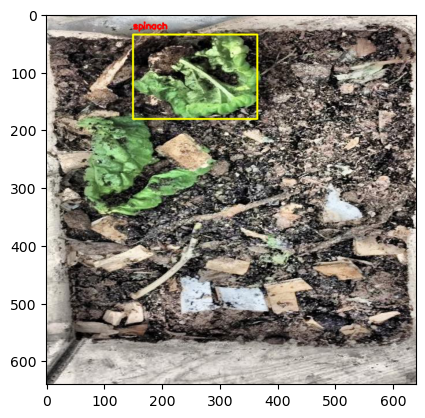

In [19]:
show_image_objects(data_train.iloc[0],"Composed Worm AI.v1i.tensorflow/train")

In [22]:
import os
import pandas as pd
import tensorflow as tf

def load_data(csv_file, images_dir, label_map):
    data = pd.read_csv(csv_file)
    images = []
    classes = []
    bboxes = []
    #Preposesing Image
    for _, row in data.iterrows():
        image_path = os.path.join(images_dir, row['filename'])
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (224, 224))
        images.append(image)

        class_label = label_map[row['class']]
        bbox = [float(row['xmin']), float(row['ymin']), float(row['xmax']), float(row['ymax'])]
        classes.append(class_label)
        bboxes.append(bbox)

    images = tf.stack(images)
    classes = tf.convert_to_tensor(classes, dtype=tf.int32)
    bboxes = tf.convert_to_tensor(bboxes, dtype=tf.float32)

    return images, (classes, bboxes)



In [23]:
# Create label map
unique_classes = pd.concat([
    pd.read_csv('Composed Worm AI.v1i.tensorflow/train/_annotations.csv')['class'],
    pd.read_csv('Composed Worm AI.v1i.tensorflow/valid/_annotations.csv')['class'],
    pd.read_csv('Composed Worm AI.v1i.tensorflow/test/_annotations.csv')['class']
]).unique()
label_map = {label: idx for idx, label in enumerate(unique_classes)}

train_images, train_targets = load_data('Composed Worm AI.v1i.tensorflow/train/_annotations.csv', 'Composed Worm AI.v1i.tensorflow/train',label_map)
verif_images, verif_targets = load_data('Composed Worm AI.v1i.tensorflow/valid/_annotations.csv', 'Composed Worm AI.v1i.tensorflow/valid',label_map)
test_images, test_targets = load_data('Composed Worm AI.v1i.tensorflow/test/_annotations.csv', 'Composed Worm AI.v1i.tensorflow/test',label_map)


In [24]:
label_map

{'spinach': 0,
 'cardboard': 1,
 'leaves': 2,
 'coffee_grounds': 3,
 'celery_leaves': 4,
 'leave': 5}

In [26]:
train_targets

(<tf.Tensor: shape=(197,), dtype=int32, numpy=
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int32)>,
 <tf.Tensor: shape=(197, 4), dtype=float32, numpy=
 array([[150.,  35., 365., 181.],
        [ 49., 175., 283., 347.],
        [188., 209., 288., 269.],
        [ 23., 236.,  75., 274.],
        [ 70.,  25., 208., 131.],
        [ 79., 350., 155., 394.],
        [ 81

# Prepare Tensor Flow Dataset

In [28]:
def create_tf_dataset(images, targets):
    dataset = tf.data.Dataset.from_tensor_slices((images, targets))
    return dataset

train_dataset = create_tf_dataset(train_images, train_targets)
verif_dataset = create_tf_dataset(verif_images, verif_targets)
test_dataset = create_tf_dataset(test_images, test_targets)

# Batch and prefetch the datasets for training
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
verif_dataset = verif_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [29]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

# Build A Model Using MobileNetV2

In [30]:
def build_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=[224, 224, 3])
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)
    bbox_output = tf.keras.layers.Dense(4, name='bbox_output')(x)

    model_net = tf.keras.Model(inputs, [class_output, bbox_output])
    return model_net

num_classes = len(label_map)
model_net = build_model(num_classes)
model_net.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 6)         │      7,686 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      5,124 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compile and Train The Model

In [8]:
losses = {
    "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
    "bbox_output": tf.keras.losses.MeanSquaredError()
}

metrics = {
    "class_output": "accuracy",
    "bbox_output": "mse"
}

model_net.compile(optimizer='adam', loss=losses, metrics=metrics)

# Train the model
history=model_net.fit(train_dataset, validation_data=verif_dataset, epochs=10)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - bbox_output_mse: 139831.7812 - class_output_accuracy: 0.2741 - loss: 137459.6094 - val_bbox_output_mse: 156624.4219 - val_class_output_accuracy: 0.2632 - val_loss: 156627.4219
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - bbox_output_mse: 137998.7500 - class_output_accuracy: 0.7508 - loss: 135655.1250 - val_bbox_output_mse: 154558.2031 - val_class_output_accuracy: 0.2632 - val_loss: 154562.7188
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - bbox_output_mse: 136223.9062 - class_output_accuracy: 0.7454 - loss: 133908.9531 - val_bbox_output_mse: 152518.0000 - val_class_output_accuracy: 0.0000e+00 - val_loss: 152523.2031
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - bbox_output_mse: 134473.1094 - class_output_accuracy: 0.9011 - loss: 132186.6094 - val_bbox_output_mse: 150500.1562 - val_class_output_accuracy: 0.0000e+00 - val_loss: 150505.5312
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - bbox_output_mse: 132744.0781

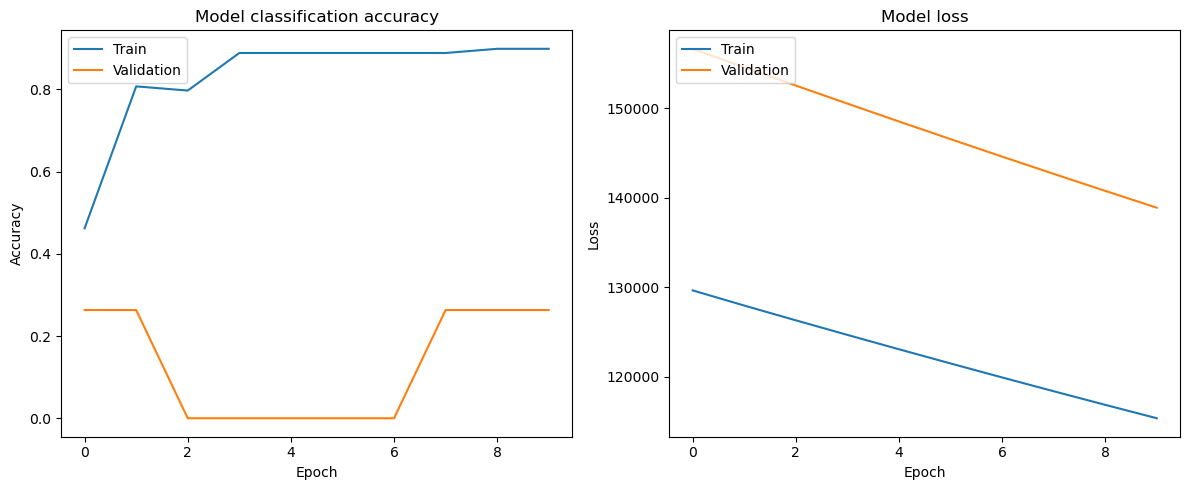

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history['val_class_output_accuracy'])
plt.title('Model classification accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
evaluation=model_net.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - bbox_output_mse: 148211.0000 - class_output_accuracy: 0.0000e+00 - loss: 148218.9375


In [11]:
# Print accuracy score
accuracy_score = evaluation[2]  # Assuming accuracy is the fourth metric in the output
print(f"Test Accuracy: {accuracy_score:.2f}")

Test Accuracy: 0.00


# Using Fuctional Model

This model modified with multiple output Class Output and BBox Output

In [12]:
# Define input layer
inputs = Input(shape=(224, 224, 3))

# Define the shared convolutional base
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

# Define the classification output
class_output = Dense(32, activation='relu')(x)
class_output = Dense(7, activation='softmax', name='class_output')(class_output)

# Define the bounding box regression output
bbox_output = Dense(32, activation='relu')(x)
bbox_output = Dense(4, name='bbox_output')(bbox_output)

# Create the model
model_aug = Model(inputs=inputs, outputs=[class_output, bbox_output])

# Compile the model
losses = {
    "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
    "bbox_output": tf.keras.losses.MeanSquaredError()
}

metrics = {
    "class_output": "accuracy",
    "bbox_output": "mse"
}

model_aug.compile(optimizer='adam', loss=losses, metrics=metrics)
model_aug.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 86528)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 86528)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │  2,768,928 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │  2,768,928 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 7)         │        231 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        132 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,631,467 (21.48 MB)

 Trainable params: 5,631,467 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history_aug=model_aug.fit(train_dataset, validation_data=verif_dataset, epochs=10)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 885ms/step - bbox_output_mse: 1808979.0000 - class_output_accuracy: 0.3752 - loss: 1769359.1250 - val_bbox_output_mse: 162879.0625 - val_class_output_accuracy: 0.0000e+00 - val_loss: 163110.5000
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 861ms/step - bbox_output_mse: 140662.5781 - class_output_accuracy: 0.3800 - loss: 137967.7656 - val_bbox_output_mse: 71599.5234 - val_class_output_accuracy: 0.0000e+00 - val_loss: 71668.7656
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 859ms/step - bbox_output_mse: 54486.1172 - class_output_accuracy: 0.6149 - loss: 54505.2930 - val_bbox_output_mse: 44867.0820 - val_class_output_accuracy: 0.0000e+00 - val_loss: 44893.7266
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 882ms/step - bbox_output_mse: 44262.4961 - class_output_accuracy: 0.5426 - loss: 45506.4453 - val_bbox_output_mse: 20308.1543 - val_class_output_accuracy: 0.0000e+00 - val_loss: 20336.9355
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 883ms/step - bbox_output_mse: 40976.2500 

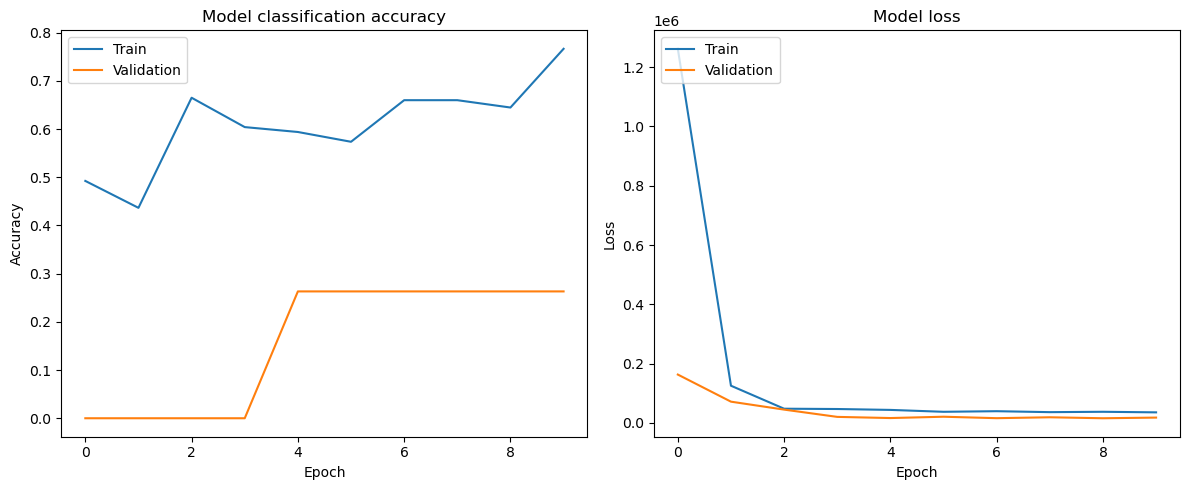

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_aug.history['class_output_accuracy'])
plt.plot(history_aug.history['val_class_output_accuracy'])
plt.title('Model classification accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
evaluation_aug=model_aug.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - bbox_output_mse: 16371.3418 - class_output_accuracy: 0.0000e+00 - loss: 16375.1240

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - bbox_output_mse: 16371.3418 - class_output_accuracy: 0.0000e+00 - loss: 16375.1240


In [16]:
# Print accuracy score
accuracy_score = evaluation[2]  # Assuming accuracy is the fourth metric in the output
print(f"Test Accuracy: {accuracy_score:.2f}")

Test Accuracy: 0.00


# Model Saving 

In [18]:
model_aug.save('model_aug_saved.h5')
model_net.save('model_net_saved.h5')

ValueError: Unable to create dataset (name already exists)